# ROI-based univariate analyses
Natalia Vélez, April 2022

In [1]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
from nilearn import image,plotting,masking
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from os.path import join as opj
from scipy.io import loadmat
from scipy import stats

sys.path.append('..')
from utils import gsearch, str_extract, print_list

sns.set_style('white')
sns.set_context('talk')

## Setup

Valid subjects:

In [2]:
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
print(subjects)

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30]


Project directory:

In [3]:
data_dir = '/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives'
model_name = 'task-teaching_model-parametric'

Find ACC:

In [4]:
acc_file = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space/bilateral_ACCg.nii.gz'
os.path.exists(acc_file)

True

Find functional ROI files:

In [5]:
roi_files = gsearch(data_dir, 'roi_picker', 'sub-*', 'func', '*.nii.gz')
roi_files.sort()

print_list(roi_files, 'ROI files')

Found 194 ROI files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-MMPFC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-PC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RSTS_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RTPJ_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-VMPFC_mask.nii.gz
/n/ger

Find contrast files:

In [6]:
con_files = gsearch(data_dir, 'glm', 'sub-*', 'func', model_name, 'con*')
con_files.sort()

print_list(con_files, 'contrast files')

Found 112 contrast files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametric/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametric/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametric/con_0003.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametric/con_0004.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametric/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametric/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametric/con_0003.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametric/con_0004.nii
/n/gershman_ncf/Lab/nat

Load contrast names:

In [7]:
con_file = opj(data_dir, 'glm', 'group', model_name, 'contrasts.mat')
con_data = loadmat(con_file)
contrasts_raw = con_data['contrasts']
contrasts = [c[0].replace('+', '') for c in contrasts_raw[0]] # all a hacky way of reading mat files

print_list(contrasts, 'contrasts')

Found 4 contrasts
pTrue
-pTrue
KL
-KL


## GLM 1: Full model with model-based regressors

### First-level contrasts

Main loop: Extract data from all ROIs

In [8]:
# Initialize output
roi_list = []

# Iterate over subjects and contrasts
for sub in subjects:
    for con_idx,con_name in enumerate(contrasts):
        
        # Format subject, contrast numbers nicely
        sub_id = 'sub-%02d' % sub
        con_id = 'con_%04d' % (con_idx+1)

        # Filter out contrast, ROI files
        sub_con = [f for f in con_files if sub_id in f and con_id in f]
        sub_con = sub_con[0] # should be a unique file

        sub_roi = [f for f in roi_files if sub_id in f]
        sub_roi.append(acc_file) # add anatomical ACC ROI
        sub_roi.sort() # list of files
                
        # Extract average t from each ROI
        for roi in sub_roi:
            roi_name = str_extract('(?<=desc-)[A-Za-z]+|ACC', roi)            
            masked_t = masking.apply_mask(sub_con, roi)
            mean_t = masked_t.mean()
            
            roi_list.append((sub, con_name, roi_name, mean_t))

In [9]:
# put it all together
roi_df = pd.DataFrame(roi_list, columns=['subject', 'contrast', 'roi', 'beta'])
roi_df['roi'] = roi_df.roi.astype('category')
roi_df = roi_df.sort_values(by=['subject', 'contrast', 'roi']).reset_index(drop=True)
print(roi_df.shape)
roi_df.head(8)

(888, 4)


,subject,contrast,roi,beta
0,1,-KL,ACC,1.744421
1,1,-KL,DMPFC,9.004334
2,1,-KL,LTPJ,4.435798
3,1,-KL,MMPFC,10.028110
4,1,-KL,PC,2.642633
5,1,-KL,RSTS,1.958421
6,1,-KL,RTPJ,3.103316
7,1,-KL,VMPFC,4.738282


Do one-sample t-tests with Bonferroni correction:

In [10]:
t_list = []

# do one-sample t-tests on average ROI betas
for name,group in roi_df.groupby(['roi', 'contrast']):
    # find CI (for plotting)
    ci_lo, ci_hi = sns.utils.ci(sns.algorithms.bootstrap(group.beta))
    group_mean = group.beta.mean()
    
    res = stats.ttest_1samp(group.beta, 0)
    t_list.append(name+(group_mean, res.statistic, res.pvalue, ci_lo, ci_hi))
    
t_df = (
    pd.DataFrame(t_list, columns=['roi', 'contrast', 'avg', 'statistic', 'pvalue', 'ci_lo', 'ci_hi'])
    .sort_values(by=['contrast', 'roi'])
    .reset_index(drop=True)
)
t_df['roi'] = t_df['roi'].astype('category')

# mark ROIs that survive Bonferroni correction
p_thresh = 0.05/(t_df.roi.nunique())
t_df['sig'] = np.where(t_df.pvalue < p_thresh, '*', '') # extra vars for plotting
t_df['sig_y'] = np.where(t_df.avg >= 0, t_df.ci_hi+.1, t_df.ci_lo-.1)
t_df['sig_x'] = t_df.roi.cat.codes-.11

t_df

,roi,contrast,avg,statistic,pvalue,ci_lo,ci_hi,sig,sig_y,sig_x
0,ACC,-KL,0.768482,3.487654,1.686150e-03,0.362957,1.191694,*,1.291694,-0.11
1,DMPFC,-KL,4.909179,6.466772,6.244915e-07,3.513360,6.409908,*,6.509908,0.89
2,LTPJ,-KL,1.852924,4.330672,1.836224e-04,1.033749,2.677551,*,2.777551,1.89
3,MMPFC,-KL,6.096414,7.816630,2.724716e-08,4.596551,7.560307,*,7.660307,2.89
4,PC,-KL,0.853468,2.154695,4.026753e-02,0.111871,1.603097,,1.703097,3.89
5,RSTS,-KL,1.647434,5.363270,1.149267e-05,1.076696,2.269781,*,2.369781,4.89
6,RTPJ,-KL,1.257126,2.760501,1.024506e-02,0.378758,2.129350,,2.229350,5.89
7,VMPFC,-KL,4.111593,5.897187,3.210765e-06,2.809694,5.476685,*,5.576685,6.89
8,ACC,-pTrue,-6.431269,-3.241250,3.155287e-03,-10.324244,-2.636552,*,-10.424244,-0.11
9,DMPFC,-pTrue,-37.589449,-4.940280,3.575789e-05,-51.927945,-22.925474,*,-52.027945,0.89


#### 1) Posterior probability of true hypothesis

Plot results:

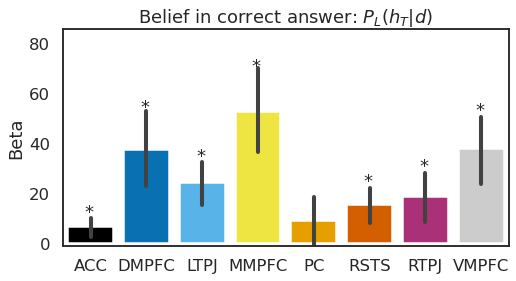

In [11]:
roi_colors = ['#000000', '#0971B2', '#58B3E9', '#EFE542', '#E5A000', '#D45F00', '#AA3177', '#CCCCCC']

pTrue_df = roi_df[roi_df.contrast == 'pTrue']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=pTrue_df, x='roi', y='beta', ax=ax, palette=roi_colors, saturation=1)

pTrue_sig = t_df[t_df.contrast == 'pTrue']
for _, row in pTrue_sig.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief in correct answer: $P_L(h_T|d)$', ylim=(
    pTrue_sig.ci_lo.min()*1.25,
    pTrue_sig.ci_hi.max()*1.25
))

plt.savefig('plots/main_pTrue.png')

#### 2) Belief update

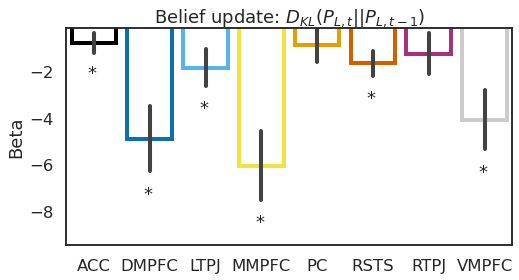

In [12]:
KL_df = roi_df[roi_df.contrast == 'KL']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=KL_df, x='roi', y='beta', fill=None, ax=ax, saturation=1)

for idx,patch in enumerate(ax.patches):
    patch.set_edgecolor(roi_colors[idx])
    patch.set_linewidth(4)

KL_sig = t_df[t_df.contrast == 'KL']
for _, row in KL_sig.iterrows():
    ax.text(row.sig_x, row.sig_y-1, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief update: $D_{KL}(P_{L,t}||P_{L,t-1})$', ylim=(
    KL_sig.ci_lo.min()*1.25,
    KL_sig.ci_hi.max()*1.25
))

plt.savefig('plots/main_KL.png')

## GLM 2: Parametric regressors derived from student responses

Shorter contrast list:

In [17]:
contrasts_trunc = ['pTrue', 'KL']

Empirical regressor files:

In [18]:
empirical_con = gsearch(data_dir, 'glm', 'sub-*', 'func', 'task-teaching_model-student', 'con*')
empirical_con.sort()

print_list(empirical_con, 'contrast files')

Found 56 contrast files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-student/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-student/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-student/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-student/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-student/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-student/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teaching_model-student/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teaching_model-student/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/d

Extract average betas from ROIs:

In [19]:
# Initialize output
empirical_list = []

# Iterate over subjects and contrasts
for sub in subjects:
    for con_idx,con_name in enumerate(contrasts_trunc):
        
        # Format subject, contrast numbers nicely
        sub_id = 'sub-%02d' % sub
        con_id = 'con_%04d' % (con_idx+1)

        # Filter out contrast, ROI files
        sub_con = [f for f in empirical_con if sub_id in f and con_id in f]
        sub_con = sub_con[0] # should be a unique file

        sub_roi = [f for f in roi_files if sub_id in f]
        sub_roi.append(acc_file) # add anatomical ACC ROI
        sub_roi.sort() # list of files
                
        # Extract average t from each ROI
        for roi in sub_roi:
            roi_name = str_extract('(?<=desc-)[A-Za-z]+|ACC', roi)            
            masked_t = masking.apply_mask(sub_con, roi)
            mean_t = masked_t.mean()
            
            empirical_list.append((sub, con_name, roi_name, mean_t))

In [20]:
# put it all together
empirical_df = pd.DataFrame(empirical_list, columns=['subject', 'contrast', 'roi', 'beta'])
empirical_df['roi'] = empirical_df.roi.astype('category')
empirical_df = empirical_df.sort_values(by=['subject', 'contrast', 'roi']).reset_index(drop=True)
print(empirical_df.shape)
empirical_df.head(8)

(444, 4)


,subject,contrast,roi,beta
0,1,KL,ACC,-0.062288
1,1,KL,DMPFC,-0.018608
2,1,KL,LTPJ,-0.277470
3,1,KL,MMPFC,-0.006135
4,1,KL,PC,-0.097709
5,1,KL,RSTS,0.025783
6,1,KL,RTPJ,-0.115453
7,1,KL,VMPFC,0.071664


Do one-sample t-tests with Bonferroni correction

In [21]:
t_list = []

# do one-sample t-tests on average ROI betas
for name,group in empirical_df.groupby(['roi', 'contrast']):
    # find CI (for plotting)
    ci_lo, ci_hi = sns.utils.ci(sns.algorithms.bootstrap(group.beta))
    group_mean = group.beta.mean()
    
    res = stats.ttest_1samp(group.beta, 0)
    t_list.append(name+(group_mean, res.statistic, res.pvalue, ci_lo, ci_hi))
    
empirical_t = (
    pd.DataFrame(t_list, columns=['roi', 'contrast', 'avg', 'statistic', 'pvalue', 'ci_lo', 'ci_hi'])
    .sort_values(by=['contrast', 'roi'])
    .reset_index(drop=True)
)
empirical_t['roi'] = empirical_t['roi'].astype('category')

# mark ROIs that survive Bonferroni correction
p_thresh = 0.05/(empirical_t.roi.nunique())
empirical_t['sig'] = np.where(empirical_t.pvalue < p_thresh, '*', '') # extra vars for plotting
empirical_t['sig_y'] = np.where(empirical_t.avg >= 0, empirical_t.ci_hi+.1, empirical_t.ci_lo-.3)
empirical_t['sig_x'] = empirical_t.roi.cat.codes-.11

empirical_t

,roi,contrast,avg,statistic,pvalue,ci_lo,ci_hi,sig,sig_y,sig_x
0,ACC,KL,-0.012803,-0.505174,0.617536,-0.062076,0.035841,,-0.362076,-0.11
1,DMPFC,KL,-0.042781,-0.730762,0.471219,-0.155278,0.067378,,-0.455278,0.89
2,LTPJ,KL,-0.038752,-0.834843,0.411133,-0.125818,0.053076,,-0.425818,1.89
3,MMPFC,KL,-0.155492,-2.398517,0.023929,-0.281754,-0.033059,,-0.581754,2.89
4,PC,KL,-0.027604,-0.955843,0.347632,-0.083018,0.026962,,-0.383018,3.89
5,RSTS,KL,-0.034413,-1.311251,0.200815,-0.085292,0.015815,,-0.385292,4.89
6,RTPJ,KL,-0.017977,-0.467611,0.643815,-0.094308,0.054244,,-0.394308,5.89
7,VMPFC,KL,-0.074562,-1.355267,0.186991,-0.180172,0.032930,,-0.480172,6.89
8,ACC,pTrue,0.590982,4.234185,0.000238,0.333339,0.869752,*,0.969752,-0.11
9,DMPFC,pTrue,3.225907,5.887467,0.000003,2.166721,4.282867,*,4.382867,0.89


Plot results:

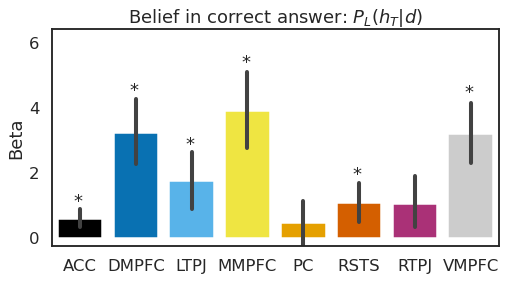

In [22]:
pTrue_df = empirical_df[empirical_df.contrast == 'pTrue']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=pTrue_df, x='roi', y='beta', ax=ax, palette=roi_colors, saturation=1)

pTrue_sig = empirical_t[empirical_t.contrast == 'pTrue']
for _, row in pTrue_sig.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief in correct answer: $P_L(h_T|d)$', ylim=(
    pTrue_sig.ci_lo.min()*1.25,
    pTrue_sig.ci_hi.max()*1.25
))

plt.savefig('plots/empirical_pTrue.png')

In [ ]:
KL_df = empirical_df[empirical_df.contrast == 'KL']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=KL_df, x='roi', y='beta', fill=None, ax=ax, saturation=1)

for idx,patch in enumerate(ax.patches):
    patch.set_edgecolor(roi_colors[idx])
    patch.set_linewidth(4)

KL_sig = empirical_t[empirical_t.contrast == 'KL']
for _, row in KL_sig.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief update: $D_{KL}(P_{L,t}||P_{L,t-1})$', ylim=(
    KL_sig.ci_lo.min()*1.25,
    KL_sig.ci_hi.max()*1.25
))

plt.savefig('plots/empirical_KL.png')

## GLM 3-4: Model-based regressors estimated in separate GLMs

#### pTrue

Regressor files:

In [13]:
pTrue_con = gsearch(data_dir, 'glm', 'sub-*', 'func', 'task-teaching_model-parametricpTrue', 'con_0001*')
pTrue_con.sort()

print_list(pTrue_con, 'contrast files')

Found 28 contrast files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-06/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-07/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-08/func/task-teaching_model-parametricpTrue/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-09/func/task-teaching_model-parametricpTr

Extract average betas from ROIs:

In [14]:
# Initialize output
pTrue_list = []

# Iterate over subjects and contrasts
for sub in subjects:
    sub_id = 'sub-%02d' % sub
    con_name = 'pTrue'
    # Filter out contrast, ROI files
    sub_con = [f for f in pTrue_con if sub_id in f]
    sub_con = sub_con[0] # should be a unique file

    sub_roi = [f for f in roi_files if sub_id in f]
    sub_roi.append(acc_file) # add anatomical ACC ROI
    sub_roi.sort() # list of files

    # Extract average t from each ROI
    for roi in sub_roi:
        roi_name = str_extract('(?<=desc-)[A-Za-z]+|ACC', roi)            
        masked_t = masking.apply_mask(sub_con, roi)
        mean_t = masked_t.mean()

        pTrue_list.append((sub, con_name, roi_name, mean_t))

In [15]:
# put it all together
pTrue_df = pd.DataFrame(pTrue_list, columns=['subject', 'contrast', 'roi', 'beta'])
pTrue_df['roi'] = pTrue_df.roi.astype('category')
pTrue_df = pTrue_df.sort_values(by=['subject', 'contrast', 'roi']).reset_index(drop=True)
print(pTrue_df.shape)
pTrue_df.head(8)

(222, 4)


,subject,contrast,roi,beta
0,1,pTrue,ACC,1.109947
1,1,pTrue,DMPFC,4.778813
2,1,pTrue,LTPJ,2.888475
3,1,pTrue,MMPFC,3.505774
4,1,pTrue,PC,3.295557
5,1,pTrue,RSTS,0.743601
6,1,pTrue,RTPJ,2.550137
7,1,pTrue,VMPFC,1.308335


Do one-sample t-tests with Bonferroni correction

In [16]:
pTrue_t_list = []

# do one-sample t-tests on average ROI betas
for name,group in pTrue_df.groupby(['roi', 'contrast']):
    # find CI (for plotting)
    ci_lo, ci_hi = sns.utils.ci(sns.algorithms.bootstrap(group.beta))
    group_mean = group.beta.mean()
    
    res = stats.ttest_1samp(group.beta, 0)
    pTrue_t_list.append(name+(group_mean, res.statistic, res.pvalue, ci_lo, ci_hi))
    
pTrue_t = (
    pd.DataFrame(pTrue_t_list, columns=['roi', 'contrast', 'avg', 'statistic', 'pvalue', 'ci_lo', 'ci_hi'])
    .sort_values(by=['contrast', 'roi'])
    .reset_index(drop=True)
)
pTrue_t['roi'] = pTrue_t['roi'].astype('category')

# mark ROIs that survive Bonferroni correction
p_thresh = 0.05/(pTrue_t.roi.nunique())
pTrue_t['sig'] = np.where(pTrue_t.pvalue < p_thresh, '*', '') # extra vars for plotting
pTrue_t['sig_y'] = np.where(pTrue_t.avg >= 0, pTrue_t.ci_hi+.1, pTrue_t.ci_lo-.3)
pTrue_t['sig_x'] = pTrue_t.roi.cat.codes-.11

pTrue_t

,roi,contrast,avg,statistic,pvalue,ci_lo,ci_hi,sig,sig_y,sig_x
0,ACC,pTrue,0.318384,2.107980,0.044456,0.029867,0.610131,,0.710131,-0.11
1,DMPFC,pTrue,1.759223,2.979217,0.006046,0.657350,2.882781,*,2.982781,0.89
2,LTPJ,pTrue,1.657580,4.823529,0.000049,1.001749,2.341864,*,2.441864,1.89
3,MMPFC,pTrue,2.698675,4.622469,0.000091,1.562796,3.832627,*,3.932627,2.89
4,PC,pTrue,0.351953,0.861587,0.396502,-0.460274,1.129033,,1.229033,3.89
5,RSTS,pTrue,0.902400,3.216371,0.003359,0.392799,1.436875,*,1.536875,4.89
6,RTPJ,pTrue,1.146814,2.706780,0.011634,0.360309,1.961855,,2.061855,5.89
7,VMPFC,pTrue,2.067227,3.186568,0.003725,0.836783,3.335716,*,3.435716,6.89


Plot results:

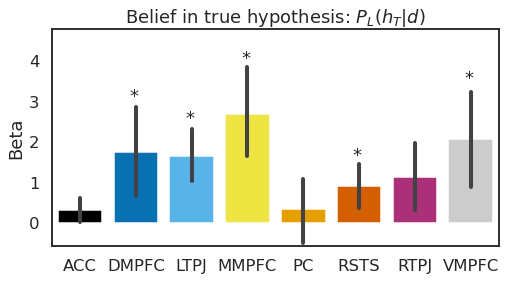

In [30]:
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=pTrue_df, x='roi', y='beta', palette=roi_colors, saturation=1, ax=ax)

for _, row in pTrue_t.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief in true hypothesis: $P_L(h_T|d)$', ylim=(
    pTrue_t.ci_lo.min()*1.25,
    pTrue_t.ci_hi.max()*1.25
))

plt.savefig('plots/separate_pTrue.png', bbox_inches='tight')

#### KL

Regressor files:

In [23]:
KL_con = gsearch(data_dir, 'glm', 'sub-*', 'func', 'task-teaching_model-parametricKL', 'con_0001*')
KL_con.sort()

print_list(KL_con, 'contrast files')

Found 28 contrast files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-06/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-07/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-08/func/task-teaching_model-parametricKL/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-09/func/task-teaching_model-parametricKL/con_0001.nii
/n/gersh

Extract average betas from ROIs:

In [24]:
# Initialize output
KL_list = []

# Iterate over subjects and contrasts
for sub in subjects:
    sub_id = 'sub-%02d' % sub
    con_name = 'pTrue'
    # Filter out contrast, ROI files
    sub_con = [f for f in KL_con if sub_id in f]
    sub_con = sub_con[0] # should be a unique file

    sub_roi = [f for f in roi_files if sub_id in f]
    sub_roi.append(acc_file) # add anatomical ACC ROI
    sub_roi.sort() # list of files

    # Extract average t from each ROI
    for roi in sub_roi:
        roi_name = str_extract('(?<=desc-)[A-Za-z]+|ACC', roi)            
        masked_t = masking.apply_mask(sub_con, roi)
        mean_t = masked_t.mean()

        KL_list.append((sub, con_name, roi_name, mean_t))

In [25]:
# put it all together
KL_df = pd.DataFrame(KL_list, columns=['subject', 'contrast', 'roi', 'beta'])
KL_df['roi'] = KL_df.roi.astype('category')
KL_df = KL_df.sort_values(by=['subject', 'contrast', 'roi']).reset_index(drop=True)
print(KL_df.shape)
KL_df.head(8)

(222, 4)


,subject,contrast,roi,beta
0,1,pTrue,ACC,-0.040740
1,1,pTrue,DMPFC,-0.355551
2,1,pTrue,LTPJ,-0.168560
3,1,pTrue,MMPFC,-0.544268
4,1,pTrue,PC,0.001453
5,1,pTrue,RSTS,-0.109257
6,1,pTrue,RTPJ,-0.047400
7,1,pTrue,VMPFC,-0.228562


Do one-sample t-tests with Bonferroni correction

In [26]:
KL_t_list = []

# do one-sample t-tests on average ROI betas
for name,group in KL_df.groupby(['roi', 'contrast']):
    # find CI (for plotting)
    ci_lo, ci_hi = sns.utils.ci(sns.algorithms.bootstrap(group.beta))
    group_mean = group.beta.mean()
    
    res = stats.ttest_1samp(group.beta, 0)
    KL_t_list.append(name+(group_mean, res.statistic, res.pvalue, ci_lo, ci_hi))
    
KL_t = (
    pd.DataFrame(KL_t_list, columns=['roi', 'contrast', 'avg', 'statistic', 'pvalue', 'ci_lo', 'ci_hi'])
    .sort_values(by=['contrast', 'roi'])
    .reset_index(drop=True)
)
KL_t['roi'] = KL_t['roi'].astype('category')

# mark ROIs that survive Bonferroni correction
p_thresh = 0.05/(KL_t.roi.nunique())
KL_t['sig'] = np.where(KL_t.pvalue < p_thresh, '*', '') # extra vars for plotting
KL_t['sig_y'] = np.where(KL_t.avg >= 0, KL_t.ci_hi+.1, KL_t.ci_lo-.1)
KL_t['sig_x'] = KL_t.roi.cat.codes-.11

KL_t

,roi,contrast,avg,statistic,pvalue,ci_lo,ci_hi,sig,sig_y,sig_x
0,ACC,pTrue,-0.038566,-2.209995,3.576897e-02,-0.072383,-0.005488,,-0.172383,-0.11
1,DMPFC,pTrue,-0.302348,-5.011891,2.949788e-05,-0.421086,-0.185225,*,-0.521086,0.89
2,LTPJ,pTrue,-0.068597,-1.829073,7.845475e-02,-0.139791,0.006465,,-0.239791,1.89
3,MMPFC,pTrue,-0.338474,-6.555128,5.972610e-07,-0.436240,-0.237210,*,-0.536240,2.89
4,PC,pTrue,-0.035922,-1.164053,2.545861e-01,-0.098086,0.021867,,-0.198086,3.89
5,RSTS,pTrue,-0.070124,-2.337014,2.710417e-02,-0.128559,-0.012528,,-0.228559,4.89
6,RTPJ,pTrue,-0.031880,-0.793784,4.342427e-01,-0.108376,0.045119,,-0.208376,5.89
7,VMPFC,pTrue,-0.199544,-3.626130,1.229525e-03,-0.311042,-0.095668,*,-0.411042,6.89


Plot results:

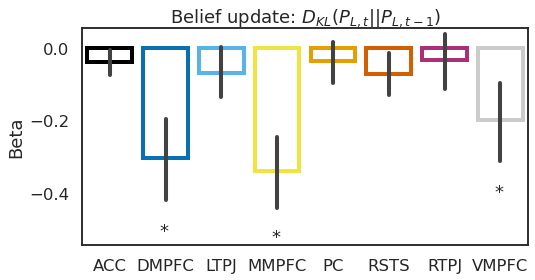

In [29]:
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=KL_df, x='roi', y='beta', fill=None, ax=ax)

for _, row in KL_t.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

for idx,patch in enumerate(ax.patches):
    patch.set_edgecolor(roi_colors[idx])
    patch.set_linewidth(4)
    
ax.set(xlabel='', ylabel='Beta', title = r'Belief update: $D_{KL}(P_{L,t}||P_{L,t-1})$', ylim=(
    KL_t.ci_lo.min()*1.25,
    KL_t.ci_hi.max()*1.25
))

plt.savefig('plots/separate_KL.png', bbox_inches='tight')